# RatNDay4 Openfield recording info

In [7]:
import numpy as np
from subjects import of

sess = of.ratNday4[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatN/Day4/RatN_Day4_2019-10-15_11-30-06.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250


# Set probe configuration
This animal had 8 shank probe from diagnostic biochips

data saved


<AxesSubplot:title={'center':'Probe 128ch'}>

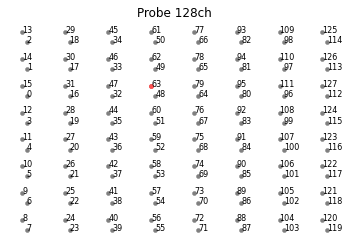

In [4]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)



# Experimental Paradigm 

In [5]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 7423, 11497,10186],
        "stop": [7407, 11483, 25987,11483],
        "label": ["pre", "maze", "post",'sprinkle'],
    }
)

a = Epoch(epochs=epochs)
a.filename = sess.filePrefix.with_suffix(".paradigm.npy")
a.save()


data saved


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Neurons
- import spiketrains from Phy
- estimate neuron types such pyramidal, interneuron etc. 

## Importing spiketrains from Phy

In [8]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatN/Day4/spykcirc/RatN_Day4_2019-10-15_11-30-06.GUI"
)

chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.peak_waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    metadata={'cluster_path':cluster_path}
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()

## Estimate neuron type

In [ ]:
%matplotlib widget
from neuropy.utils import neurons_util
neuron_type = neurons_util.estimate_neuron_type(sess.neurons)
sess.neurons.neuron_type = neuron_type

In [ ]:
neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster

plot_raster(neurons,color='jet',add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data

In [10]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=0.25)

/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 03.58.37 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 04.08.48 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 04.10.41 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 07.19.00 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 08.15.29 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 08.55.22 AM.csv


In [11]:
import pandas as pd
from datetime import datetime

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(sync_time,unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# ------- deleting intervals that were deleted from .dat file after concatenating
ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
for i in range(ndeletedintervals):
    tnoisy_begin = data_time[0] + pd.Timedelta(
        rec_datetime["deletedStart (minutes)"][i], unit="m"
    )
    tnoisy_end = data_time[0] + pd.Timedelta(
        rec_datetime["deletedEnd (minutes)"][i], unit="m"
    )

    del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[
        0
    ]

    data_time = np.delete(data_time, del_index)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)

In [12]:
position.filename = sess.filePrefix.with_suffix('.position.npy')
position.save()

data saved


In [13]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(position.x,position.y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([40])

spec = signal_process.spectrogramBands(signal.traces[0])


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/500)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.y)*100)
plt.xlim([12500,12600])
plt.ylim([-400,400])

## Linearize position

In [ ]:
from neuropy.utils import position_util

maze = sess.paradigm['maze']
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)

In [ ]:
linear_pos.y

In [ ]:
%matplotlib widget
plt.plot(maze_pos.time,maze_pos.x)
plt.plot(linear_pos.time,linear_pos.x)

In [ ]:
import numpy as np

a = np.ones(5)
np.vstack((a,a,a)).shape

In [ ]:
from neuropy.core import animal

d = {'name':'hello','tag':'ser'}

an = animal.Animal(d) 
